# NON-INTERACTING (HARD-CORE / U=0) CASE

Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")

HSP_T (generic function with 1 method)

In [2]:
using QuantumOptics

## Initial Parameters

In [3]:
Nx=3; Ny=3; N=Nx*Ny; q=Ny; PN=1; T_size=5;

## Create Single-Particle Operator

In [4]:
function Op_Sp(Nx, Ny, alpha, Tx, Ty)
        
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    basis = NLevelBasis(N) 
    
    H = SparseOperator(basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(basis, m, n)
        end
    end
    
    return H
end

Op_Sp (generic function with 1 method)

In [5]:
# CHECK: Operator Form
using LinearAlgebra
Tx=Ty=0
op = Op_Sp(Nx, Ny, 1/q, Tx, Ty)
eigenenergies(dense(op)) == eigvals(HSP_T(Nx, Ny, 1/q, Tx, Ty, 0))
eigenenergies(dense(op))

9-element Vector{Float64}:
 -2.73205080756888
 -2.7320508075688767
 -2.7320508075688767
  0.7320508075688769
  0.7320508075688773
  0.7320508075688781
  1.9999999999999991
  2.0
  2.0000000000000004

## Create Many-Basis for Hard-Core Interaction

In [6]:
basis = NLevelBasis(N)
states = bosonstates(basis, PN)
basis_mb = ManyBodyBasis(basis, states)

function get_mb_op(basis_mb, op)
    H_mb2 = SparseOperator(basis_mb) 
    for m in 1:N
        for n in 1:N
            H_mb2 += op.data[m,n] * transition(basis_mb, m, n)
        end
    end
    
    return H_mb2
end

get_mb_op (generic function with 1 method)

In [7]:
# CHECK: MB Structure (PN=1)
#eigenenergies(dense(H_mb)) == eigvals(HSP_T(Nx, Ny, 1/q, Tx, Ty, 0))
eigenenergies(dense(H_mb))

LoadError: UndefVarError: H_mb not defined

In [8]:
# Ortogonality Check !
E, V = eigen(dense(H_mb).data)
dot(V[:,1],V[:,2])

LoadError: UndefVarError: H_mb not defined

## Crete Mesh of Twisted-Angle Space

\begin{equation}
\theta_\mu = \frac{2\pi}{N_\theta}n_\mu
\end{equation}

In [9]:
dx=2*pi/T_size
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

## Energies of Many-Body Hofstadter Model

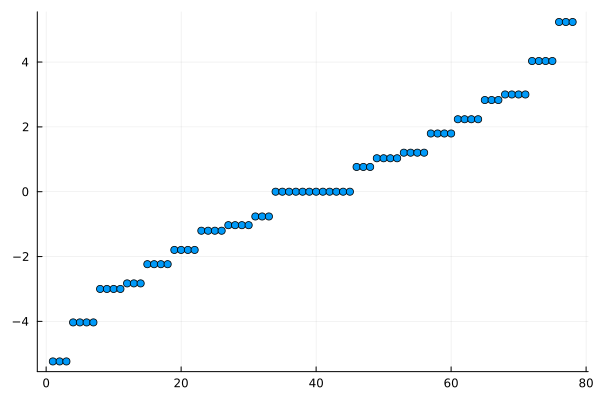

In [10]:
using Plots
E = eigenenergies(dense(H_mb))
plot(1:length(E),E,seriestype=:scatter,legend=false)

# Cherns

Berry Curvature:
\begin{equation}
\mathcal{F}(\vec{\theta}) = \log \left( U_x(\vec{\theta})U_y(\vec{\theta}+\delta_x)U_x(\vec{\theta}+\delta_y)^{-1}U_y(\vec{\theta})^{-1} \right)
\end{equation}
Link variables:
\begin{equation}
U_\mu(\vec{\theta}) = \frac{
det \left( \Phi(\vec{\theta})^\dagger \Phi(\vec{\theta}+\delta_\mu) \right) 
}{
| det \left(\Phi(\vec{\theta})^\dagger \Phi(\vec{\theta}+\delta_\mu) \right) |} , \quad \delta_x = \left(\frac{2\pi}{N_{\theta}},0 \right), \delta_y = \left(0, \frac{2\pi}{N_{\theta}}\right)
\end{equation}
Chern Number:
\begin{equation}
\mathcal{C} = \frac{1}{2\pi i} \sum_{\vec{\theta}} \mathcal{F}(\vec{\theta})
\end{equation}

In [11]:
# executeme

function Chern_Nums(Tx, Ty, n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w1, v1 = eigen(dense(H_mb).data)
            i = sortperm(w1, by=real);w1 = w1[i];v1 = v1[:,i]
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w2, v2 = eigen(dense(H_mb).data)
            i = sortperm(w2, by=real);w2 = w2[i];v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w3, v3 = eigen(dense(H_mb).data)
            i = sortperm(w3, by=real);w3 = w3[i];v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w4, v4 = eigen(dense(H_mb).data)
            i = sortperm(w4, by=real);w4 = w4[i];v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 1 method)

In [12]:
Chern_Nums(Tx, Ty, 1, 2)

0.0025761874998864874 - 1.9566140154684676e-16im

# TEST

In [13]:
using NBInclude; using QuantumOptics; using Plots; using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")
function Chern(Nx::Int64, Ny::Int64, alpha, TSize::Int64, PN::Int64, PlotBands::Bool, n1::Int64, n2::Int64)

    # Single Particle #
    N = Nx*Ny
    function Op_Sp(Nx, Ny, alpha, Tx, Ty)    
        H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
        basis = NLevelBasis(N) 
        H = SparseOperator(basis)
        for m in 1:N
            for n in 1:N
                H = H + H_T[m,n] * transition(basis, m, n)
            end
        end
        return H
    end
    # ---- #

    # Fermionic Many-Body #
    basis = NLevelBasis(N)
    states = fermionstates(basis, PN)
    basis_mb = ManyBodyBasis(basis, states)
    function get_mb_op(basis_mb, op)
        H_mb2 = SparseOperator(basis_mb) 
        for m in 1:N
            for n in 1:N
                H_mb2 += op.data[m,n] * transition(basis_mb, m, n)
            end
        end
        return H_mb2
    end
    # ---- #
    
    # Plot #
    if PlotBands == true
        Tx=Ty=0
        op = Op_Sp(Nx, Ny, 1/q, Tx, Ty)
        Hamiltonian = get_mb_op(basis_mb, op)
        E = eigenenergies(dense(Hamiltonian))
        P = scatter(1:length(E),E,legend=false, xlabel="n", ylabel="E", title="Energy Bands")
        display(P)
    end
    # ---- #

    # Twist Angle Parameter Space #
    dx=2*pi/TSize
    dy=dx
    Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
    Ty=collect(range(start=0, stop=2*pi-dy, step=dy))
    # ---- #

    # Link Variable and Berry Curvature #
    Sum=0
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w1, v1 = eigen(dense(H_mb).data)
            i = sortperm(w1, by=real);w1 = w1[i];v1 = v1[:,i]
            v1 = v1[:,n1:n2]  
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w2, v2 = eigen(dense(H_mb).data)
            i = sortperm(w2, by=real);w2 = w2[i];v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w3, v3 = eigen(dense(H_mb).data)
            i = sortperm(w3, by=real);w3 = w3[i];v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w4, v4 = eigen(dense(H_mb).data)
            i = sortperm(w4, by=real);w4 = w4[i];v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F 
        end
    end
    # ---- #
    
    return print("Chern Number is: ",1/(2*pi*1im)*Sum)
end

Chern (generic function with 1 method)

$\nu = \frac{N}{N_\phi}, N_\phi = N_y$

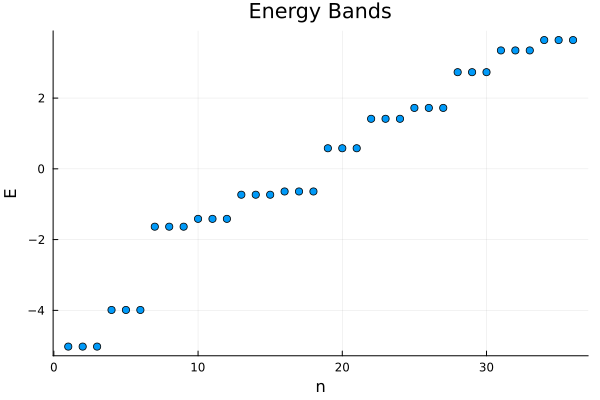

Chern Number is: 0.9999999999999994 + 5.107661597836391e-17im

In [28]:
Nx=3; Ny=3; N=Nx*Ny; q=Ny; PN=2; TSize=5
PlotBands = true
n1 = 1
n2 = 3
Chern(Nx::Int64, Ny::Int64, alpha, TSize::Int64, PN::Int64, PlotBands::Bool, n1::Int64, n2::Int64)

# Check with "Hofstadter FBA Chern Numbers" file

In [11]:
pn = 1
tx = 3
ty = 5
#---
op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty])
H_mb = get_mb_op(basis_mb, op)
w1, v1 = eigen(dense(H_mb).data)
i = sortperm(w1, by=real);w1 = w1[i];v1 = v1[:,i]
#---
op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty])
H_mb = get_mb_op(basis_mb, op)
w2, v2 = eigen(dense(H_mb).data)
i = sortperm(w2, by=real);w2 = w2[i];v2 = v2[:,i]
#---
op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty]+dy)
H_mb = get_mb_op(basis_mb, op)
w3, v3 = eigen(dense(H_mb).data)
i = sortperm(w3, by=real);w3 = w3[i];v3 = v3[:,i]
#---
op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty]+dy)
H_mb = get_mb_op(basis_mb, op)
w4, v4 = eigen(dense(H_mb).data)
i = sortperm(w4, by=real);w4 = w4[i];v4 = v4[:,i]
#---
U1=det(adjoint(v1)*v2)
U1=U1/abs(U1)
println(U1)
U2=det(adjoint(v2)*v4)
U2=U2/abs(U2)
println(U2)
U3=det(adjoint(v3)*v4)
U3=U3/abs(U3)
println(U3)
U4=det(adjoint(v1)*v3)
U4=U4/abs(U4)
v1

0.9809160820440624 + 0.19443158176419312im
-0.5779056111859718 - 0.8161036114120365im
-0.7713119060306723 - 0.6364573384095207im


9×9 Matrix{ComplexF64}:
 -0.147471+0.0656584im     -0.457078+0.0882541im  …   -0.182417-0.465181im
 -0.108016+0.119964im     -0.0339319+0.339055im        0.183004+0.519911im
  0.279226+0.362548im       0.148272+0.233568im       0.0130477-0.444643im
  0.130597-0.0948846im     -0.333868+0.131345im       0.0269058+0.0550627im
 -0.161427-3.59034e-17im    0.198994+0.0482746im     -0.0343644-0.294833im
  0.431089+0.153526im     -0.0375862+0.0152434im  …  -0.0901528+0.120994im
  0.267535+0.0152501im     -0.292739+0.382597im         0.22277+0.071743im
 -0.207476+0.169591im       0.418671+0.104825im       -0.184821+0.21235im
   0.57735+0.0im                 0.0+0.0im                  0.0+0.0im

In [14]:
w1

9-element Vector{Float64}:
 -2.361468766185822
 -2.361468766185821
 -2.36146876618582
 -0.1674491911085343
 -0.16744919110853385
 -0.1674491911085325
  2.5289179572943614
  2.528917957294362
  2.528917957294362

In [23]:
v1[:,9]

9-element Vector{ComplexF64}:
 -0.18241671659639822 - 0.4651806321186302im
  0.18300426082588966 + 0.5199111999766637im
 0.013047736325309464 - 0.4446432643394994im
 0.026905769636793052 + 0.055062744526548135im
 -0.03436435922413883 - 0.2948328103346958im
 -0.09015282409414997 + 0.12099424317644919im
   0.2227697963997299 + 0.07174304027985492im
  -0.1848214956621234 + 0.21234956642753136im
                  0.0 + 0.0im

In [18]:
w1

LoadError: UndefVarError: w1 not defined

In [19]:
w2

LoadError: UndefVarError: w2 not defined

In [20]:
w3

LoadError: UndefVarError: w3 not defined

In [21]:
w4

LoadError: UndefVarError: w4 not defined

In [22]:
det(v1'*v2)

LoadError: UndefVarError: v1 not defined

In [23]:
v1

LoadError: UndefVarError: v1 not defined

In [24]:
v2

LoadError: UndefVarError: v2 not defined

In [25]:
v1'*v2

LoadError: UndefVarError: v1 not defined